<a href="https://colab.research.google.com/github/programminghistorian/jekyll/blob/gh-pages/assets/choropleth-maps-python-folium/choropleth-maps-python-folium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction / Overview

This Jupyter notebook collects all the code from the *Programming Historian* lesson 'Creating Choropleth Maps with Python and Folium': https://doi.org/10.46430/phen0126 

**Make sure to run all the code cells in order!** Jupyter notebooks load data into the computer's memory in the sequence in which they are executed, *not* the order they appear in the notebook. So if you try to run cell $3$ without running cell $2$, it might not work.



Load the libraries needed for the lesson.


In [1]:
#!pip install geopandas

import pandas as pd
import geopandas as gpd
import folium
import numpy as np

## Get the Data

### Fatal Force Data

Get the data to be visualized on the choropleth map.
* the default first line will access the datafile on the *Programming Historian* archive
* the second -- commented out -- will load the up-to-date version of the datafile from the *Washington Post*'s archive.

If you wish to load the most recent version of the data, edit the next cell to comment out the first two lines and delete the `#` signs on the second two.

In [2]:
ff_df = pd.read_csv('https://raw.githubusercontent.com/programminghistorian/jekyll/gh-pages/assets/choropleth-maps-python-folium/fatal-police-shootings-data.csv',
                    parse_dates = ['date'])
# ff_df = pd.read_csv('https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv',
#                    parse_dates = ['date'])

Examine the data.

In [3]:
ff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9628 entries, 0 to 9627
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          9628 non-null   int64         
 1   date                        9628 non-null   datetime64[ns]
 2   threat_type                 9560 non-null   object        
 3   flee_status                 8315 non-null   object        
 4   armed_with                  9416 non-null   object        
 5   city                        9557 non-null   object        
 6   county                      4912 non-null   object        
 7   state                       9628 non-null   object        
 8   latitude                    8567 non-null   float64       
 9   longitude                   8567 non-null   float64       
 10  location_precision          8567 non-null   object        
 11  name                        9293 non-null   object      

In [4]:
ff_df.sample(5)

id       date threat_type flee_status armed_with          city  \
2154  2400 2017-03-04       point         not        gun  Fountain Inn   
553    677 2015-07-25       shoot         not        gun       Decatur   
4956  5363 2020-01-10      threat         car    unarmed       Spokane   
1754  1962 2016-10-12      threat         car        gun     Las Vegas   
4707  5117 2019-10-20       point         not    replica         Boise   

          county state   latitude   longitude location_precision  \
2154  Greenville    SC  34.731396  -82.181132      not_available   
553      Decatur    GA  30.848699  -84.734911      not_available   
4956         NaN    WA  47.720496 -117.422026      not_available   
1754       Clark    NV  36.169941 -115.139830      not_available   
4707         NaN    ID  43.638757 -116.233557      not_available   

                       name   age  gender race    race_source  \
2154  Joseph Scott Inabinet  50.0    male    W  not_available   
553          Roger Braswell  50.0    male    W  not_available   
4956          Clando Anitok  25.0    male    A  not_available   
1754       Rex Vance Wilson  50.0    male  NaN            NaN   
4707       Amber Lea Dewitt  33.0  female    W  not_available   

      was_mental_illness_related  body_camera agency_ids  
2154                        True        False        395  
553                         True        False        677  
4956                       False        False       2264  
1754                       False         True        375  
4707                        True         True        349

In [5]:
ff_df['latitude'].notna()

0        True
1        True
2        True
3        True
4        True
        ...  
9623    False
9624     True
9625     True
9626     True
9627     True
Name: latitude, Length: 9628, dtype: bool

What percent of records have latitude / longitude data?



In [6]:
len(ff_df[ff_df['latitude'].notna()]) / len(ff_df)

0.8898005816368924

Drop all the rows that do not have lat/lon data.

In [7]:
ff_df = ff_df[ff_df['latitude'].notna()]

### County Geometry Data

Get the datafiles that have geometry shape data for US counties.

As above, first line has the datafile archived by *Programming Historian*. The second has the URL to access the data at the US Census bureau.

In [8]:
counties = gpd.read_file('https://raw.githubusercontent.com/programminghistorian/jekyll/gh-pages/assets/choropleth-maps-python-folium/cb_2021_us_county_5m.zip')

# counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip")


Examine the county geometry data.

In [9]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     3234 non-null   object  
 1   COUNTYFP    3234 non-null   object  
 2   COUNTYNS    3234 non-null   object  
 3   AFFGEOID    3234 non-null   object  
 4   GEOID       3234 non-null   object  
 5   NAME        3234 non-null   object  
 6   NAMELSAD    3234 non-null   object  
 7   STUSPS      3234 non-null   object  
 8   STATE_NAME  3234 non-null   object  
 9   LSAD        3234 non-null   object  
 10  ALAND       3234 non-null   int64   
 11  AWATER      3234 non-null   int64   
 12  geometry    3234 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 328.6+ KB


In [10]:
counties.sample(3)

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME      NAMELSAD  \
1963      17      103  00424253  0500000US17103  17103      Lee    Lee County   
514       51      770  01498439  0500000US51770  51770  Roanoke  Roanoke city   
2448      37      043  01008546  0500000US37043  37043     Clay   Clay County   

     STUSPS      STATE_NAME LSAD       ALAND    AWATER  \
1963     IL        Illinois   06  1877189070   9732924   
514      VA        Virginia   25   110129436    855753   
2448     NC  North Carolina   06   556804503  15017755   

                                               geometry  
1963  POLYGON ((-89.62933 41.90162, -89.47999 41.902...  
514   POLYGON ((-80.03346 37.26289, -80.01467 37.270...  
2448  POLYGON ((-84.00458 34.99445, -83.97985 35.005...

Just for fun, pick a county you're familiar with and see what it looks like:

<Axes: >

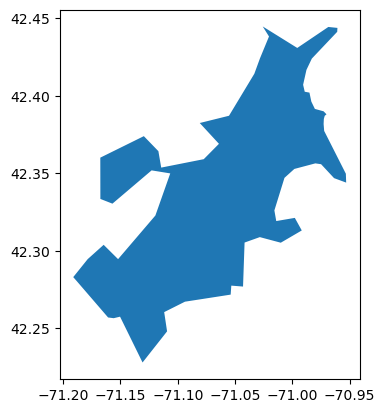

In [11]:
counties[(counties['NAME']=='Suffolk') & (counties['STUSPS']=='MA')].plot()

Rename the `GEOID` column as `FIPS` and drop all columns not needed for this lesson.

In [12]:
counties = counties.rename(columns={'GEOID':'FIPS'})
counties = counties[['FIPS','NAME','geometry']]
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      3234 non-null   object  
 1   NAME      3234 non-null   object  
 2   geometry  3234 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 75.9+ KB


### Preparing the Data
1. Add a `points` column to the **Fatal Force** dataframe, using the `EPSG:4326` CRS.
1. Convert the **Counties** dataframe to the `EPSG:4326` CRS



In [13]:
ff_df['points'] = gpd.points_from_xy(ff_df.longitude, ff_df.latitude, crs="EPSG:4326")
ff_df = gpd.GeoDataFrame(data=ff_df,geometry='points')

In [14]:
counties = counties.to_crs('EPSG:4326')
counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Add `FIPS` data to the **Fatal Force** DF.

In [15]:
ff_df = gpd.sjoin(left_df = ff_df,
                  right_df = counties,
                  how = 'left')

Check the **Fatal Force** DF to make sure the data has been added correctly.

In [16]:
ff_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8567 entries, 0 to 9627
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          8567 non-null   int64         
 1   date                        8567 non-null   datetime64[ns]
 2   threat_type                 8512 non-null   object        
 3   flee_status                 7489 non-null   object        
 4   armed_with                  8368 non-null   object        
 5   city                        8536 non-null   object        
 6   county                      4654 non-null   object        
 7   state                       8567 non-null   object        
 8   latitude                    8567 non-null   float64       
 9   longitude                   8567 non-null   float64       
 10  location_precision          8567 non-null   object        
 11  name                        8303 non-null   object   

## Summarizing the Data by County

Create a DF that sums the number of police killings in each county in the **Fatal Force** DF.


In [17]:
map_df = ff_df[['FIPS']].value_counts()
map_df

FIPS 
06037    341
04013    224
48201    139
06071    114
32003    102
        ... 
29105      1
29107      1
29109      1
29113      1
56033      1
Name: count, Length: 1593, dtype: int64

Convert the value counts series into a DF.

In [18]:
map_df = map_df.reset_index()
map_df

FIPS  count
0     06037    341
1     04013    224
2     48201    139
3     06071    114
4     32003    102
...     ...    ...
1588  29105      1
1589  29107      1
1590  29109      1
1591  29113      1
1592  56033      1

[1593 rows x 2 columns]

If the prior cell doesn't rename the `count` column, run the next cell to do so.

In [ ]:
map_df.rename(columns={0:'count'})
map_df
                

## Draw the Map

Create a function that will allow us to easily initialize a Folium map variable.

In [19]:
def initMap():
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
    attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'

    center = [40,-96]

    map = folium.Map(location=center,
                zoom_start = 5,
                tiles = tiles,
                attr = attr)
    return map

In [21]:
baseMap = initMap()

Once we have inititalized the map, we can draw the map and display it.

In [ ]:
folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)'
        ).add_to(baseMap)

baseMap # this displays the map

## The Problem of Uneven Distribution of Data

Why does the map look so uniform?

Examine the underlying data.


In [23]:
map_df.describe()

count
count  1593.000000
mean      5.372881
std      14.196364
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max     341.000000

Visualize the data with a boxplot.

<Axes: >

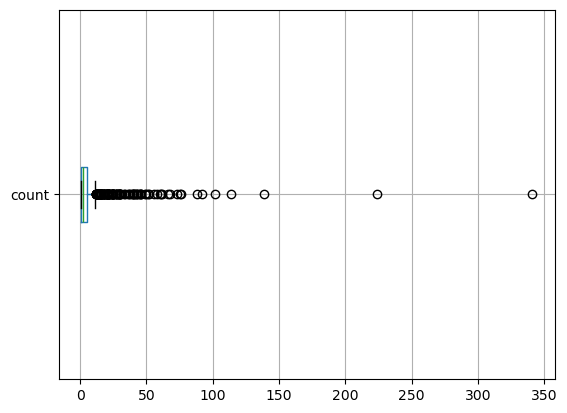

In [24]:
map_df.boxplot(vert=False)

### Solution #1: Fisher-Jenks algorithm

Because Colab's standard collection of libraries does not include the `jenkspy`, we need to install it.

Then change the `folium.Choroplet()` call to include the Fisher-Jenks algorithm and redraw the map.

In [ ]:
! pip install jenkspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.3/611.3 kB 7.4 MB/s eta 0:00:00


Now that the `jenkspy` library is installed, we can pass the parameter to Folium and redraw our map.

In [ ]:
 baseMap = initMap()
 # we need to initialize the map again; if we don't, it will add our new cholopleth map to the existing map
 # alternately, we could create a new map (m2 = ...)

folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present)',
        use_jenks = True, # <-- this is the new parameter we're passing to Folium
        ).add_to(baseMap)

baseMap # this displays the map


### Solution #2: Create a scale variable


#### Create a Logarithm Scale-Value

1. Import numpy
2. Add a `MapScale` column to the **map_df** with data to use for the colors/scale on the map.



In [26]:
import numpy as np
map_df['MapScale'] = map_df['count'].apply(lambda x: np.log10(x) if x>0 else 0)


Remove the `use_jenks` parameter and change the column of data we want to use for the scale, then redraw the map.

In [ ]:
 baseMap = initMap()
 # we need to initialize the map again; if we don't, it will add our new cholopleth map to the existing map
 # alternately, we could create a new map (m2 = ...)
folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'], # <== change the column to use for map colors
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log scale)'
        ).add_to(baseMap)

baseMap # this displays the map


Redraw the map with the code to diplay the labels on the scale with non-log values.

In [ ]:
baseMap = initMap()

cp = folium.Choropleth( #<== cp is the variable that has been added
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log scale)'
        ).add_to(baseMap)

from branca.element import Element
e = Element("""
  var ticks = document.querySelectorAll('div.legend g.tick text')
  for(var i = 0; i < ticks.length; i++) {
    var value = parseFloat(ticks[i].textContent.replace(',', ''))
    var newvalue = Math.pow(10.0, value).toFixed(0).toString()
    ticks[i].textContent = newvalue
  }
""")
colormap = cp.color_scale # this finds the color scale in the cp variable
html = colormap.get_root()
html.script.get_root().render()
html.script.add_child(e)

baseMap


## Normalizing the Data




### Get County Population Data

Get the data from the census bureau and examine it.

(If the Github repo doesn't work, swap the lines that are commented (`#`) out.)



In [30]:
url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
#url = 'https://github.com/programminghistorian/jekyll/blob/gh-pages/assets/choropleth-maps-python-folium/co-est2019-alldata.csv'

pop_df = pd.read_csv(url,
                     usecols = ['STATE','COUNTY','POPESTIMATE2019'],
                     encoding = "ISO-8859-1")
pop_df.head()

STATE  COUNTY  POPESTIMATE2019
0      1       0          4903185
1      1       1            55869
2      1       3           223234
3      1       5            24686
4      1       7            22394

In [31]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   STATE            3193 non-null   int64
 1   COUNTY           3193 non-null   int64
 2   POPESTIMATE2019  3193 non-null   int64
dtypes: int64(3)
memory usage: 75.0 KB


### Prepare the data

Create a `FIPS` column by converting integers into strings and adding leading zeros.

Then reexamine the data.

In [32]:
pop_df['STATE'] = pop_df['STATE'].astype(str).str.zfill(2) # convert to string, and add leading zeros
pop_df['COUNTY'] = pop_df['COUNTY'].astype(str).str.zfill(3)
pop_df['FIPS'] = pop_df['STATE'] + pop_df['COUNTY'] # combine the state and county fields to create a FIPS
pop_df.head()


STATE COUNTY  POPESTIMATE2019   FIPS
0    01    000          4903185  01000
1    01    001            55869  01001
2    01    003           223234  01003
3    01    005            24686  01005
4    01    007            22394  01007

### Add population data to the **map_df** dataframe.

And then re-examine the data.

In [33]:
map_df = map_df.merge(pop_df, on = 'FIPS', how = 'left')
map_df.head()

FIPS  count  MapScale STATE COUNTY  POPESTIMATE2019
0  06037    341  2.532754    06    037       10039107.0
1  04013    224  2.350248    04    013        4485414.0
2  48201    139  2.143015    48    201        4713325.0
3  06071    114  2.056905    06    071        2180085.0
4  32003    102  2.008600    32    003        2266715.0

Calculate the number of police killings per 100K population.

In [34]:
map_df['count_per_100K'] = map_df['count'] / (map_df['POPESTIMATE2019']/100000)
map_df.head()

FIPS  count  MapScale STATE COUNTY  POPESTIMATE2019  count_per_100K
0  06037    341  2.532754    06    037       10039107.0        3.396716
1  04013    224  2.350248    04    013        4485414.0        4.993965
2  48201    139  2.143015    48    201        4713325.0        2.949086
3  06071    114  2.056905    06    071        2180085.0        5.229154
4  32003    102  2.008600    32    003        2266715.0        4.499904

## Draw the Normalized Map

In [ ]:
baseMap = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','count_per_100K'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (per 100K population)'
        ).add_to(baseMap)

baseMap

### Uneven Data, redux

Examine the `count_per_100K` variable and visualize it.


In [36]:
map_df['count_per_100K'].describe()

count    1592.000000
mean        5.478407
std         6.133838
min         0.179746
25%         2.160387
50%         3.797904
75%         6.626440
max        71.123755
Name: count_per_100K, dtype: float64

<Axes: >

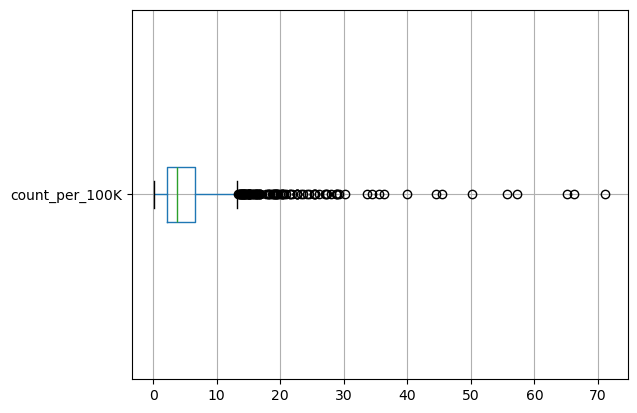

In [37]:
map_df.boxplot(column=['count_per_100K'],vert=False)

### Convert the `count_per_100K` into log values.

Then re-draw the boxplot.

<Axes: >

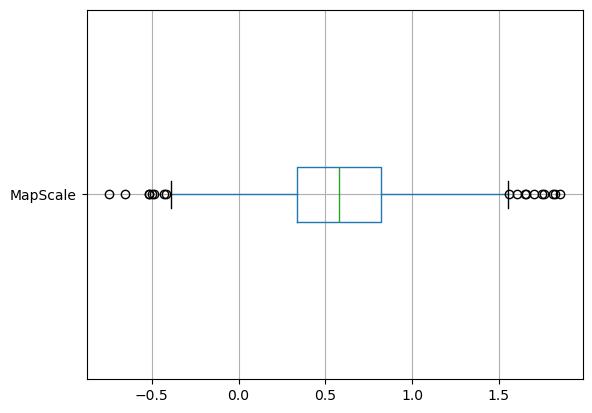

In [38]:
map_df['MapScale'] = np.log10(map_df['count_per_100K'])
map_df.boxplot(column=['MapScale'],vert=False)

### Redraw the map

Note that the code to display the scale indexes as non-log values has been included.

In [ ]:
baseMap = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings per 100K population (2015-present) (log scale)'
        ).add_to(baseMap)

from branca.element import Element
e = Element("""
  var ticks = document.querySelectorAll('div.legend g.tick text')
  for(var i = 0; i < ticks.length; i++) {
    var value = parseFloat(ticks[i].textContent.replace(',', ''))
    var newvalue = Math.pow(10.0, value).toFixed(0).toString()
    ticks[i].textContent = newvalue
  }
""")
colormap = cp.color_scale # this finds the color scale in the cp variable
html = colormap.get_root()
html.script.get_root().render()
html.script.add_child(e)

baseMap

## Improving Folium Maps


### Add a Floating Information Box

This code is deceiptively simple. See the article for a description of what's going on.

To simplify this, the code to change the map scale to non-log values has been removed.

In [ ]:
baseMap = initMap()

cp = folium.Choropleth( #<== cp is the variable that has been added
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log-scale)'
        ).add_to(baseMap)

map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'

folium.GeoJsonTooltip(['NAME','count'],aliases=['County:','N killed by Police:']).add_to(cp.geojson)

baseMap

A more complicated example of the floating information box displaying multiple variables.

In [ ]:
baseMap = initMap()

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings per 100K population (2015-present) (log scale)'
        ).add_to(baseMap)

map_data_lookup = map_df.set_index('FIPS')

for row in cp.geojson.data['features']:
  try:
      row['properties']['count'] = f"{(map_data_lookup.loc[row['properties']['FIPS'],'count']):.0f}"
  except KeyError:
      row['properties']['count'] = 'No police killings reported'
  try:
      row['properties']['count_per_100K'] = f"{map_data_lookup.loc[row['properties']['FIPS'],'count_per_100K']:.2f}" # present the data with 2 decimal places
  except KeyError:
      row['properties']['count_per_100K'] = 'No data'
  try:
      row['properties']['population'] = f"{map_data_lookup.loc[row['properties']['FIPS'],'POPESTIMATE2019']:,.0f}"
  except KeyError:
      row['properties']['population'] = 'No data'

folium.GeoJsonTooltip(['NAME','population','count','count_per_100K'],
                      aliases=['county:','population:','count:','per100K:']
                      ).add_to(cp.geojson)

baseMap

### Add a Mini Map


In [ ]:
from folium import plugins
minimap = plugins.MiniMap()
baseMap.add_child(minimap)

baseMap

### Add a Title
Adding a title to the Folium map.



In [ ]:
baseMap = initMap()

titleText = """Number of people killed by police in each county"""
title_html = '''
             <h4 align="center" style="font-size:16px"><b>{}</b></h4>
             '''.format(titleText)
baseMap.get_root().html.add_child(folium.Element(title_html))

cp = folium.Choropleth(
        geo_data = counties,
        data = map_df,
        columns = ['FIPS','MapScale'],
        key_on = 'feature.properties.FIPS',
        bins = 9,
        fill_color='OrRd',
        fill_opacity=0.8,
        line_opacity=0.2,
        nan_fill_color = 'grey',
        legend_name='Number of Fatal Police Shootings (2015-present) (log scale)'
        ).add_to(baseMap)

baseMap

## Saving Maps

Save the map as a HTML file.

In [48]:
baseMap.save('PoliceKillingsOfCivilians.html')